In [2]:
# Librairies classiques
import pandas as pd
import numpy as np
import scipy.ndimage
import scipy
import datetime
from time import time

%matplotlib inline
import matplotlib.pyplot as plt

# Deux librairies différentes pour les images
from PIL import Image, ImageTk
import cv2

CT_DIR_DATA = 'MSO_DATA/'
CT_DIR_DATA_IMAGES = 'MSO_DATA/images/'

# Quelques méthodes

In [2]:
def read_image(file, pillow=False):
    if pillow:
        return np.array(Image.open(file))
    return cv2.imread(file, cv2.CV_32S)

def read_gray_image(file, pillow=False):
    # Read and convert to gray
    if pillow:
        return np.array(Image.open(file).convert('L'))
    return cv2.imread(file, cv2.IMREAD_GRAYSCALE)

def save_image(file, img, pillow=False):
    # Read and convert to gray
    if pillow:
        return img.save(file)
    return cv2.imwrite(file, img)

def resize_image(image, w_min, h_min, pillow=False):
    if pillow:
        return np.array(image.resize((w_min, h_min), Image.ANTIALIAS))
        # img = flatten_image(img)
    return cv2.resize(image, (w_min, h_min))
        # img = img.flatten()

def show_rgb_img(img, pillow=False):
    if pillow:
        return img.show()
    """Convenience function to display a typical color image"""
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def show_gray_img(img, pillow=False):
    if pillow:
        return img.show()
    plt.imshow(img, cmap='gray');

def to_gray(color_img, pillow=False):
    # Read and convert to gray
    if pillow:
        return color_img.convert('L')
    return cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    
def to_sift_features(lst_img, pillow):
    ret = []
    for img in lst_img:
        kp, desc = gen_sift_features(img, pillow)
        ret.append(desc)
    return ret
        
def gen_sift_features(gray_img, pillow=False):
    if pillow:
        raise Exception('gen_sift_features-Pillow-TODO')
    else:
        sift = cv2.xfeatures2d.SIFT_create()
        # kp is the keypoints
        # desc is the SIFT descriptors, they're 128-dimensional vectors
        # that we can use for our final features
        kp, desc = sift.detectAndCompute(gray_img, None)
        return kp, desc


# P7 : Classez et segmentez des données visuelles

## Analyse d'une image

### Histogramme des niveaux de gris

In [447]:
def showHisto(img):
    # Calcul de l'histogramme, plusieurs manières :
    hist,bins = np.histogram(img.flatten(),256,[0,256])
#     hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    fig = plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.title('Image'), show_gray_img(img);
    plt.subplot(122)
    plt.plot(cdf_normalized, color = 'b')
#     plt.plot(hist2, color = 'g')
    plt.hist(img.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('Histogramme cumulé','Histogramme'), loc = 'upper left')
    plt.title('Histogramme'), 
    # Générer et afficher l'histogramme
    # Pour le normaliser : argument density=True dans plt.hist
    # Pour avoir l'histogramme cumulé : argument cumulative=True
    # n, bins, patches = plt.hist(img.flatten(), bins=range(256))
    plt.show()    

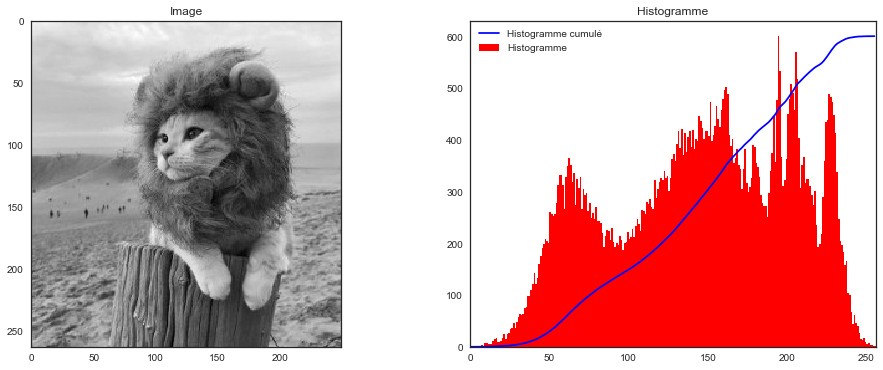

In [448]:
# Charger l'image
img = read_gray_image(CT_DIR_DATA + "simba.png") 

showHisto(np.array(img))

### Egalisation d'histogramme

Image et son histogramme après égalisation


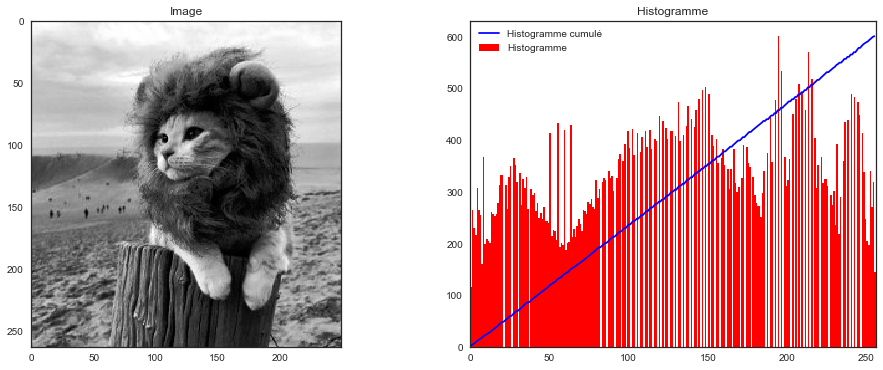

In [449]:
print('Image et son histogramme après égalisation')
equ = cv2.equalizeHist(img)
showHisto(equ)

### Seuillage

Image avant et après seuillage


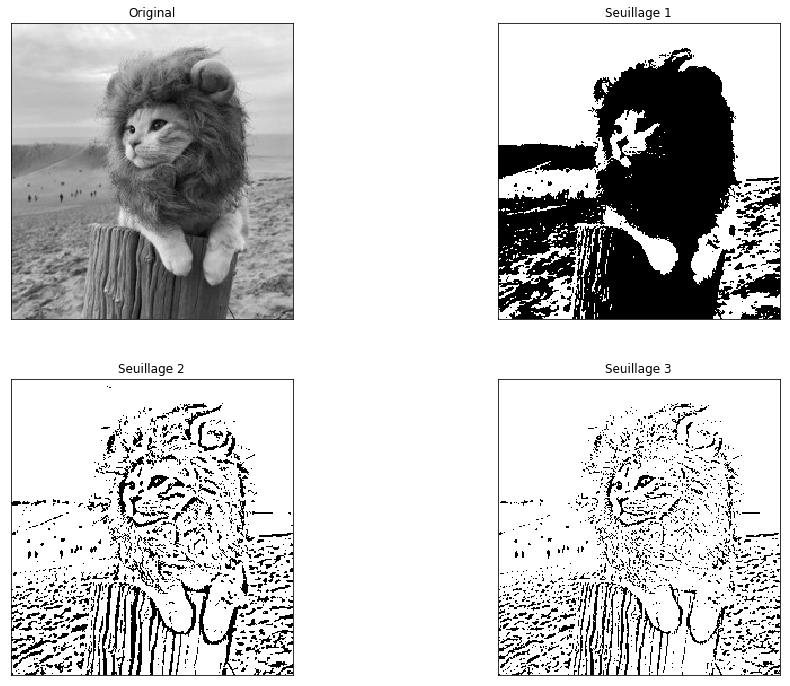

In [325]:
img = read_gray_image(CT_DIR_DATA + 'simba.png')

# Les valeurs supérieures ou égales à 150 sont mises à 255, les autres à 0
(retVal, img1) = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

# Threshold adaptatif en utilisant des voisinages de 9 (doit être impair) et en mettant les valeurs au-dessus de la moyenne locale moins 10 à la valeur 255.
img2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 10)

# Idem, mais au lieu de faire une simple moyenne, c'est une moyenne pondérée par des coefficients gaussiens.
img3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 10)

print('Image avant et après seuillage')
fig = plt.figure(figsize=(16, 12))
plt.subplot(2,2,1),plt.imshow(img, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(img1, cmap = 'gray')
plt.title('Seuillage 1'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(img2, cmap = 'gray')
plt.title('Seuillage 2'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(img3, cmap = 'gray')
plt.title('Seuillage 3'), plt.xticks([]), plt.yticks([])
plt.show()

### Filtres

Image avant et après filtrage


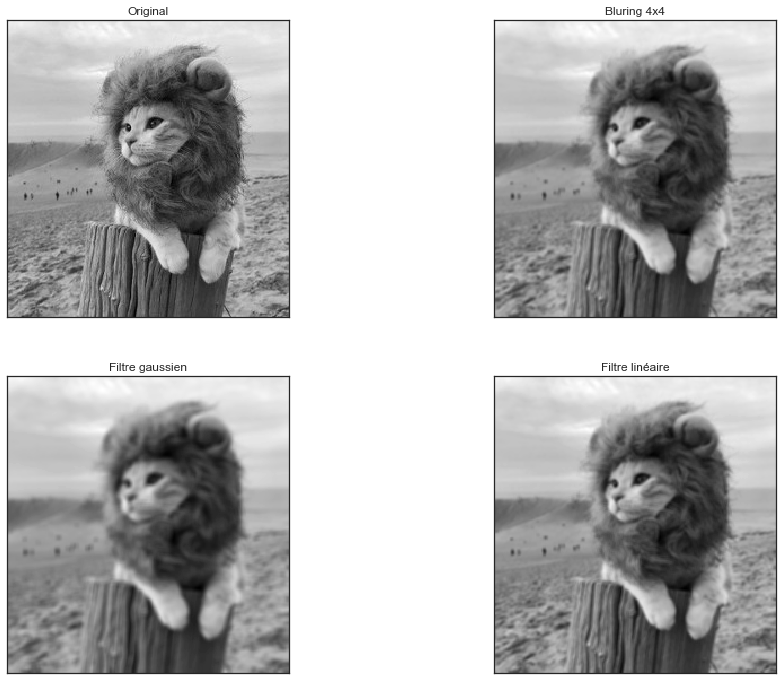

In [451]:
img = read_gray_image(CT_DIR_DATA + 'simba.png')

# Fait une moyenne dans un voisinage
blur = cv2.blur(img, (5,5))
# Filtre gaussien de taille 5 x 5 et d'écart-type 3
gauss = cv2.GaussianBlur(img, (5, 5), 3)
# gauss = scipy.ndimage.filters.gaussian_filter(img, sigma=3.0)
# Filtre linéaire quelconque
img2 = cv2.filter2D(img, -1, np.array([[1 for i in range(3)] for j in range(3)], dtype = np.float) / 9)

print('Image avant et après filtrage')
fig = plt.figure(figsize=(16, 12))
plt.subplot(2,2,1), plt.imshow(img, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2), plt.imshow(blur, cmap = 'gray')
plt.title('Bluring 5x5'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3), plt.imshow(gauss, cmap = 'gray')
plt.title('Filtre gaussien'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4), plt.imshow(img2, cmap = 'gray')
plt.title('Filtre linéaire'), plt.xticks([]), plt.yticks([])
plt.show()

### Détection des arêtes

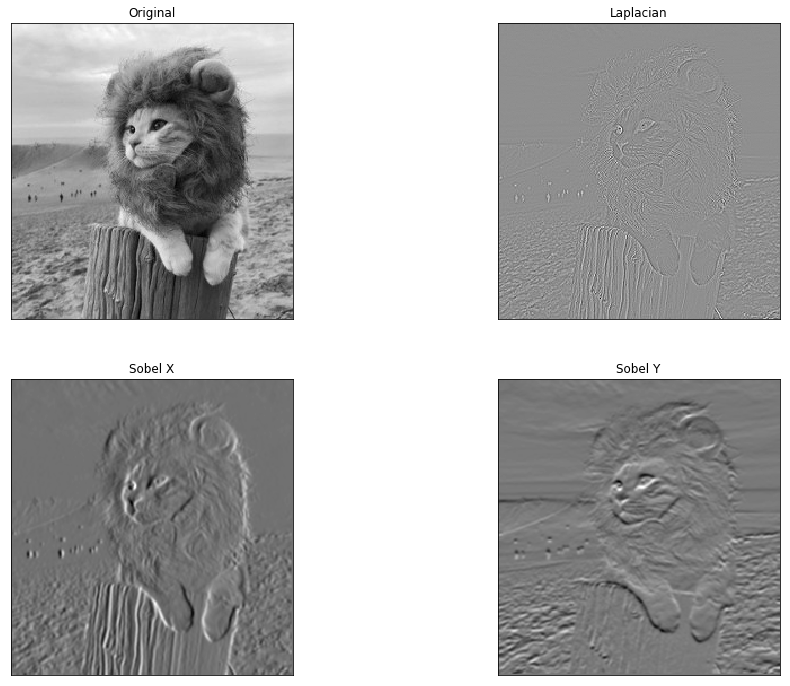

In [16]:
# Filtres laplacien et Sobel : détection des arêtes
img = read_gray_image(CT_DIR_DATA + 'simba.png')

# Filtre laplacien qui consiste à prendre la dérivée seconde
laplacian = cv2.Laplacian(img,cv2.CV_64F)
# Filtre de Sobel, qui consiste en un moyennage et la prise d'une dérivée discrète
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

fig = plt.figure(figsize=(16, 12))
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

### Détection de bords

Image avant et après détection de bords


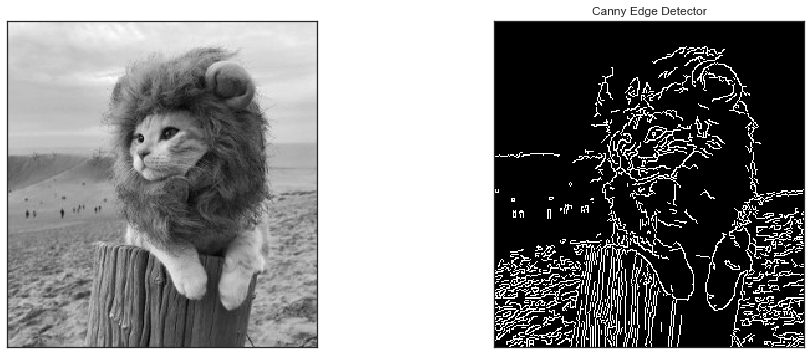

In [465]:
# Utilisation d'un filtre de Canny pour la détection de bords
# Charger l'image sous forme d'une matrice de pixels
img = read_gray_image(CT_DIR_DATA + 'simba.png')

print('Image avant et après détection de bords')
edges = cv2.Canny(img,100,200)

fig = plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.xticks([]), plt.yticks([])
show_gray_img(img)
plt.subplot(122),plt.title('Canny Edge Detector')
plt.xticks([]), plt.yticks([])
show_gray_img(edges)


### Détection de coins

Image avant et après détection de coins


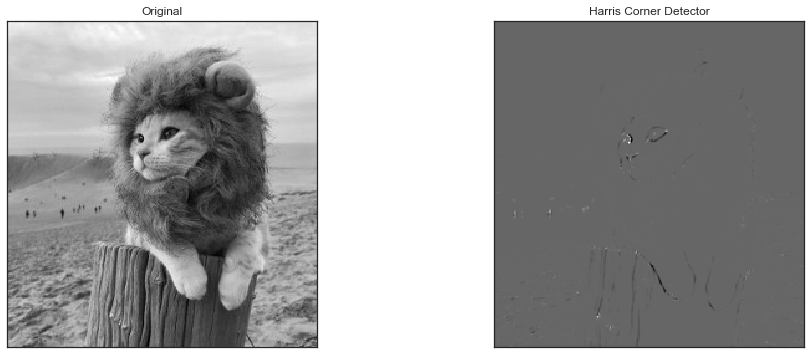

In [463]:
img = read_gray_image(CT_DIR_DATA + 'simba.png')

# Paramètres de cornerHarris
# img - Input image, it should be grayscale and float32 type.
# blockSize - It is the size of neighbourhood considered for corner detection
# ksize - Aperture parameter of Sobel derivative used.
# k - Harris detector free parameter in the equation.
img_modified = cv2.cornerHarris(img,2,3,0.04)

# Avec seuillage éventuellement
# dst = cv2.dilate(img_modified,None)
# ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
# img_modified = np.uint8(dst)

print('Image avant et après détection de coins')
fig = plt.figure(figsize=(16, 6))
plt.subplot(121),plt.title('Original')
show_gray_img(img)
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.title('Harris Corner Detector')
plt.xticks([]), plt.yticks([])
show_gray_img(img_modified)
plt.show()

### Whitening

Image avant et après whitening


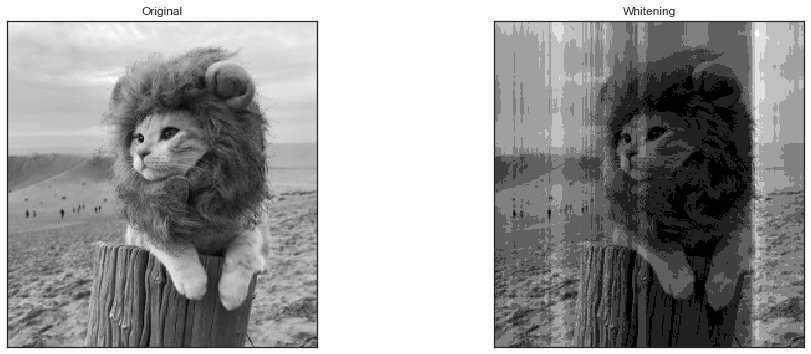

In [397]:
from scipy.cluster.vq import whiten
img = read_gray_image(CT_DIR_DATA + 'simba.png')

img_modified = whiten(img)
img_modified = np.uint8(img_modified)

print('Image avant et après whitening')
fig = plt.figure(figsize=(16, 6))
plt.subplot(121),plt.title('Original')
show_gray_img(img)
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.title('Whitening')
plt.xticks([]), plt.yticks([])
show_gray_img(img_modified)
plt.show()

## SIFT features in OpenCV

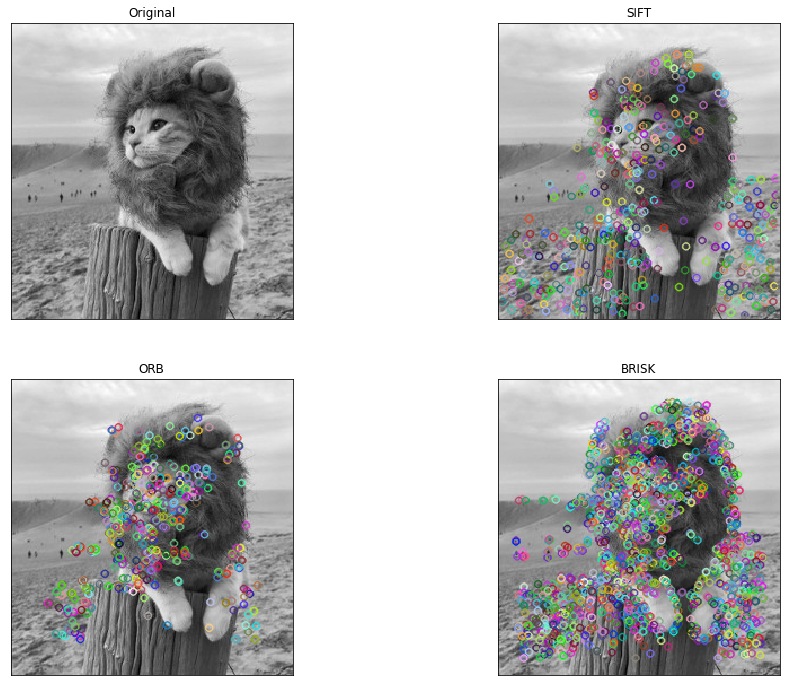

In [114]:
# img = cv2.imread(CT_DIR_DATA + "dog.jpg")
img = read_image(CT_DIR_DATA + 'simba.png')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = read_gray_image(CT_DIR_DATA + 'simba.png')

sift = cv2.xfeatures2d.SIFT_create()
surf = cv2.xfeatures2d.SURF_create()
orb = cv2.ORB_create()
brisk = cv2.BRISK_create()

kpSift = sift.detect(gray, None)
kpSurf = surf.detect(gray, None)
kpOrb = orb.detect(gray, None)
kpBrisk = brisk.detect(gray, None)

imgSift = cv2.drawKeypoints(img, kpSift, None)
imgSurf = cv2.drawKeypoints(img, kpSurf, None)
imgOrb = cv2.drawKeypoints(img, kpOrb, None)
imgBrisk = cv2.drawKeypoints(img, kpBrisk, None)

# output1 = np.hstack([imgSift, imgSurf])
# output2 = np.hstack([imgOrb, imgBrisk])
# output = np.vstack([output1, output2])
# fig = plt.figure(figsize=(16, 10))
# plt.title('SIFT vs SURF vs ORB vs BRISK')
# plt.axis('off')
# show_rgb_img(output);

fig = plt.figure(figsize=(16, 12))
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(imgSift,cmap = 'gray')
plt.title('SIFT'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(imgOrb,cmap = 'gray')
plt.title('ORB'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(imgBrisk,cmap = 'gray')
plt.title('BRISK'), plt.xticks([]), plt.yticks([])
plt.show()

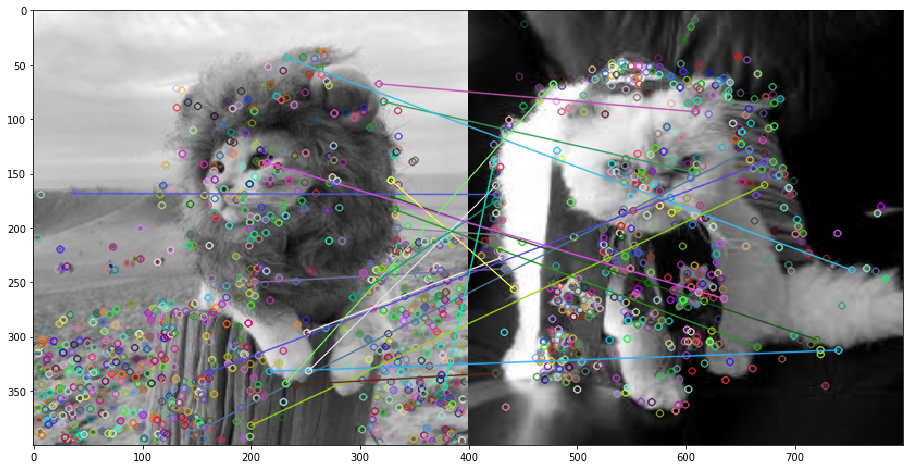

In [21]:
img = resize_image(read_gray_image(CT_DIR_DATA + 'simba.png'), 400, 400)
img2 = resize_image(read_gray_image(CT_DIR_DATA + "cat.jpg"), 400, 400)

img_kp, img_desc = gen_sift_features(img)
img_kp2, img_desc2 = gen_sift_features(img2)

# create a BFMatcher object which will match up the SIFT features
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(img_desc, img_desc2)

# Sort the matches in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw the top N matches
N_MATCHES = 20

match_img = cv2.drawMatches(
    img, img_kp,
    img2, img_kp2,
    matches[:N_MATCHES], img.copy(), flags=0)

plt.figure(figsize=(16,8))
plt.imshow(match_img);

In [22]:
def explain_keypoint(kp):
    print ('angle :', kp.angle)
    print ('class_id :', kp.class_id)
    print ('octave (image scale where feature is strongest) :', kp.octave)
    print ('pt (x,y)', kp.pt)
    print ('response', kp.response)
    print ('size', kp.size)

print ("Contenu d'un keypoint :")
explain_keypoint(img_kp[0])

Contenu d'un keypoint :
angle : 77.89791870117188
class_id : -1
octave (image scale where feature is strongest) : 4195071
pt (x,y) (3.8898844718933105, 209.1926727294922)
response 0.02278376929461956
size 2.39856219291687


In [417]:
# print ('SIFT descriptors are vectors of shape', img_desc[0].shape)
# print ('they look like this:')
print(len(img_desc[0]))
print(len(img_desc))

128
100


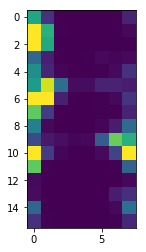

In [24]:
# Visualisation d'un descripteur
plt.imshow(img_desc[0].reshape(16,8), interpolation='none');

## Analyse d'un dossier

In [3]:
# Librairies classiques
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageTk
from scipy.cluster.vq import whiten
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing, cluster, decomposition
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Load and resize
def load_images(lst_files, w_min=200, h_min=200):
    ret = []
    for file in lst_files:
        # Convert to gray
        img = read_gray_image(file)
        img_resize = resize_image(img, w_min, h_min)
        ret.append(img_resize)
    return np.array(ret)

def getDescriptors(images, lbl):
    lstDesc = []
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=100)
    for img in images:
        kp, desc = sift.detectAndCompute(img, None)
        lstDesc.append(desc)
    # Création d'un bag of words de descripteurs et de leurs labels en y
    bow = lstDesc[0]
    y_bow = lbl[0] * np.ones(lstDesc[0].shape[0]).reshape(-1,1)
    for i, d in enumerate(lstDesc[1:]):
        bow = np.vstack((bow, d))
        y_bow = np.vstack((y_bow, lbl[i]*np.ones(d.shape[0]).reshape(-1,1)))
    return lstDesc, bow, y_bow

def select_n_components(var_ratio, goal_var: float) -> int:
    total_variance = 0.0
    n_components = 0
    for explained_variance in var_ratio:
        total_variance += explained_variance
        n_components += 1
        if total_variance >= goal_var:
            break
    # Return the number of components
    return n_components
    
# Affichage du nuage de points en 2D
def displayPCA(X, y):
    print("PCA")
    if X.ndim == 3:
        print("X.ndim =", str(X.ndim))
        X = [x.flatten()/255 for x in X]

#     X = StandardScaler().fit_transform(X)
    cls = decomposition.PCA(n_components=None, whiten=False)
    X_red = cls.fit_transform(X)
    print('Variance Explained 2 composants :', np.sum(cls.explained_variance_ratio_[:2]), end = '\n')
    plt.scatter(X_red[:,0], X_red[:,1], c=y)
    plt.title('Feature Contribution to Principal Components')
    plt.xlabel('PC1'), plt.ylabel('PC2')
    plt.show()
    print('Nombre de dimensions original :', X.shape[1])
    pct = 0.9
    best_n_components = select_n_components(cls.explained_variance_ratio_, pct)
    print(best_n_components, ' dimensions pour', int(pct*100), '% de variance')
    return best_n_components


In [5]:
# Classe de l'objet décrivant mon répertoire d'images
class myImages:
   
    # Constructeur
    # Chargement des images du dossier CT_DIR_DATA_IMAGES
    # On peut se limiter à p_nb_races races de chiens
    def __init__(self, p_dir, p_nb_races, w_min=200, h_min=200):
#         self.races = dict([(f.split('-')[0], f[f.find('-') + len('-'):]) for f in os.listdir(p_dir)])
        nb_races = 0
        self.races = []
        for f in os.listdir(p_dir):
            self.races.append((f.split('-')[0], f[f.find('-') + len('-'):]))
            nb_races += 1
            if nb_races == p_nb_races: break
        self.races = dict(self.races)
        print(len(self.races), 'races :', list(self.races.values()))
        
        # Liste des fichiers
        self.lst_files = []
        images = []
        nb_races = 0
        for path, dirs, files in os.walk(CT_DIR_DATA_IMAGES):
            if len(files) > 0: nb_races += 1
            for filename in files:
                images.append(filename)
                self.lst_files.append(os.path.join(path, filename))
            # Si on a assez de races on arrête
            if nb_races == p_nb_races: break

        self.labels = [i.split('_')[0] for i in images]
        print(len(images), 'images')

        # Target
        y = [self.races[lbl] for lbl in self.labels]
        self.lbl = LabelEncoder()
        self.y_enc = self.lbl.fit_transform(y)

        # si size=32,32 ou 200,200 : Pour l'AUC moyenne pas de changement sauf le temps de calcul
        self.data = load_images(self.lst_files, w_min=w_min, h_min=h_min)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.y_enc, test_size=0.3, 
                                                                                stratify=self.y_enc, random_state=0)


    def img_trans(self, img):
        img = cv2.Canny(img,100,200)
        # Threshold adaptatif en utilisant des voisinages de 9 (doit être impair) et en mettant les valeurs au-dessus de la moyenne locale moins 10 à la valeur 255.
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 10)
        return img

        # Préparation des données
    def prepareData(self, p_whiten=False, p_norm=False, p_pca=False, p_histo=False, p_canny=False):
#         print("Training", end=', ')
        Xtrain = self.X_train
        Xtest = self.X_test

        # Canny
        if p_canny:
            Xtrain = [self.img_trans(x) for x in self.X_train]
            Xtest = [self.img_trans(x) for x in self.X_test]
        
        # Flatten
        Xtrain = [x.flatten() for x in self.X_train]
        Xtest = [x.flatten() for x in self.X_test]
        
        # Normalisation
        if p_norm:
            print('Normalisation')
            Xtrain = [x / 255 for x in Xtrain]
            Xtest = [x / 255  for x in Xtest]

        # Whitening
        if p_whiten:
            print('Whiten')
            # Each feature is divided by its standard deviation across all observations to give it unit variance.
            Xtrain = whiten(Xtrain)
            Xtest = whiten(Xtest)

        # Histogramme
        if p_histo:
            Xtrain = []
            Xtest = []
            for i in range(len(self.X_train)):
                hist, bins = np.histogram(self.X_train[i],256,[0,256])
                Xtrain.append(hist)
            for i in range(len(self.X_test)):
                hist, bins = np.histogram(self.X_test[i],256,[0,256])
                Xtest.append(hist)

        # Réduction
#         if p_pca:
#             print("PCA, best_n_components =", str(self.best_n_components))
#             pca = PCA(n_components=self.best_n_components, svd_solver='randomized', whiten=False)
#             Xtrain = pca.fit_transform(Xtrain)
#             Xtest = pca.transform(Xtest)

#         for x in Xtrain:
#             print('len X :', len(x))
        print('len X0 :', len(Xtrain[0]))
        return Xtrain, Xtest

    def _gridSearch(self, Xtrain, Xtest, mod, param_grid):
        cls = GridSearchCV(mod, param_grid, cv=5, scoring='accuracy')
        X = np.concatenate((Xtrain, Xtest), axis=0)
        y = np.concatenate((self.y_train, self.y_test), axis=0)
        cls.fit(X, y)
        print("\tAccuracy = %.2f (Meilleurs paramètres : %s" % (cls.best_score_, cls.best_params_))
        print('\tTrain accuracy : %.2f' % accuracy_score(self.y_train, cls.predict(Xtrain)))
        return cls

    def _fit_predict(self, Xtrain, Xtest, cls):
        cls.fit(Xtrain, self.y_train)
        print('\tTrain accuracy : %.2f' % accuracy_score(self.y_train, cls.predict(Xtrain)))
        best_res = accuracy_score(self.y_test, cls.predict(Xtest))
        print('\tTest accuracy : %.2f' % best_res)
        return best_res
        
    def mySVC(self, Xtrain, Xtest):
        print('SVC :')
        if len(self.races) > 2:
            # Meilleur paramétrage trouvé par GridSearch
            cls = SVC(C=1, tol=1e-6, kernel='rbf')
            best_res = self._fit_predict(Xtrain, Xtest, cls)
        else:
            # GridSearchCV
            mod = SVC()
            C_range = np.logspace(-2, 3, 6)
            tol_range = np.logspace(-6, -1, 6)
            gamma_range = 10. ** np.arange(-5, 4)
            kernel_range = ['linear', 'rbf', 'poly']
            param_grid = {'C': C_range, 'gamma': gamma_range, 'tol': tol_range, 'kernel' : kernel_range}
            cls = self._gridSearch(Xtrain, Xtest, mod, param_grid)
            best_res = cls.best_score_
        return best_res

    def myKNN(self, Xtrain, Xtest):
        print('KNN :')
        if len(self.races) > 2:
            # Meilleur paramétrage trouvé par GridSearch
            cls = KNeighborsClassifier(n_neighbors=7)
            best_res = self._fit_predict(Xtrain, Xtest, cls)
        else:
            # GridSearchCV
            mod = KNeighborsClassifier()
            param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}
            cls = self._gridSearch(Xtrain, Xtest, mod, param_grid)
            best_res = cls.best_score_
        return best_res

    def myRegLog(self, Xtrain, Xtest):
        print('LogisticRegression :')
        if len(self.races) > 2:
            # Meilleur paramétrage trouvé par GridSearch
            cls = LogisticRegression(C=0.1, penalty='l1')
            best_res = self._fit_predict(Xtrain, Xtest, cls)
        else:
            # GridSearchCV
            mod = LogisticRegression()
            C_range = np.logspace(-3, 3, 7)
            penalty = ['l1','l2']
            param_grid = {'C': C_range, 'penalty': penalty}
            cls = self._gridSearch(Xtrain, Xtest, mod, param_grid)
            best_res = cls.best_score_
        return best_res

    # évolution du coefficient de silhouette sur notre nuage de points
    def myKMeans(self, Xtrain, Xtest): 
        print('KMeans :')
        sil = []
        X = Xtrain
        for nu in range(2, 10):
            cls = cluster.KMeans(n_clusters=nu, n_init=1, init='random')
            cls.fit(X)
            si = silhouette_score(X, cls.labels_)
            sil.append(si)
        plt.plot(range(2, 10), sil, marker='o')
        plt.show()

    # Préparation et entrainement de nos données selon différents pré process et différents algorithmes  
    def myTraining(self, p_whiten=False, p_norm=False, p_pca=False, p_histo=False, p_canny=False):
        # Préparation des données
        Xtrain, Xtest = self.prepareData(p_whiten, p_norm, p_pca, p_histo, p_canny)

        # Réduction dimensionnelle sur l'ensemble des données, juste pour un affichage 2D
        X = np.concatenate((Xtrain, Xtest), axis=0)
        y = np.concatenate((self.y_train, self.y_test), axis=0)
        self.best_n_components = displayPCA(X, y)
        if p_pca:
            # Peu d'intérêt car les temps de calculs ne sont pas long, on risque surtout de perdre en précision
            cls = decomposition.PCA(n_components=self.best_n_components, whiten=True)
            cls.fit(X)
            Xtrain = cls.transform(Xtrain)
            Xtest = cls.transform(Xtest)
        
        res = []
        res.append(self.mySVC(Xtrain, Xtest))
        res.append(self.myRegLog(Xtrain, Xtest))
        res.append(self.myKNN(Xtrain, Xtest))
        self.myKMeans(Xtrain, Xtest)
        return np.max(res)

    # Histogramme d'une image
    def hist(self, i=0):
        n, bins, patches = plt.hist(self.data[i], bins=range(256))
        plt.show()

    # Préparation des descripteurs
    def prepareDesc(self, p_whiten=False, p_canny=False, p_sobel_x=False, p_sobel_y=False, p_laplace=False):
        X = self.data
        if p_whiten:
            X = whiten(X)
            X = np.uint8(X)
        if p_canny:
            X = [cv2.Canny(img,100,200) for img in X]
        if p_sobel_x:
            X = [cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5) for img in X]
            X = np.uint8(X)
        if p_sobel_y:
            X = [cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5) for img in X]
            X = np.uint8(X)
        if p_laplace:
            X = [cv2.Laplacian(img,cv2.CV_64F) for img in X]
            X = np.uint8(X)
            
        # Récupération des descripteurs SIFT
        self.desc, self.bow, self.y_bow = getDescriptors(X, self.y_enc)
        print('Nombre de descripteurs :', len(self.bow))


## Chargement des images

Quelques stats...

In [11]:
%%time
from PIL import Image
CT_DIR_DATA_IMAGES = 'C:\Work\OpenClassrooms\data\P7\Images/'
images = []
lst_w = []
lst_h = []
lst_mode = []
for path, dirs, files in os.walk(CT_DIR_DATA_IMAGES):
    for filename in files:
        images.append(filename)
        img = Image.open(os.path.join(path, filename))
        w, h = img.size
        lst_w.append(w)
        lst_h.append(h)
        lst_mode.append(img.mode)
        img.close()

print(len(images), 'images')
print('w min =', np.min(lst_w))
print('h min =', np.min(lst_h))
print('w max =', np.max(lst_w))
print('h max =', np.max(lst_h))
print('w moy =', np.mean(lst_w))
print('h moy =', np.mean(lst_h))

lst_wh = []
for i in range(len(images)):
    lst_wh.append(lst_w[i]*lst_h[i])
print('size min =', np.min(lst_wh))
print('size max =', np.max(lst_wh))

print('mode =', set(lst_mode))


20579 images
w min = 97
h min = 100
w max = 3264
h max = 2562
w moy = 442.529083046
h moy = 385.861752272
size min = 10500
size max = 7990272
mode = {'RGBA', 'RGB'}
Wall time: 36.8 s


## Etude avec 2 classes

In [476]:
%%time
# CT_DIR_DATA_IMAGES = '../images/'
CT_DIR_DATA_IMAGES = 'C:\Work\OpenClassrooms\data\P7\Images/'
# Chargement des images
mesImages = myImages(CT_DIR_DATA_IMAGES, p_nb_races=2, w_min=200, h_min=200)

2 races : ['Chihuahua', 'Japanese_spaniel']
337 images
Wall time: 654 ms


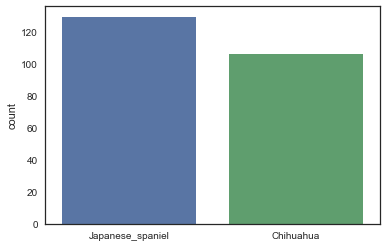

In [472]:
# Répartition des classes dans le test set target
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
sns.countplot(mesImages.lbl.inverse_transform(mesImages.y_train))

## Transformations classiques

len X0 : 256
PCA
Variance Explained 2 composants : 0.34426291155


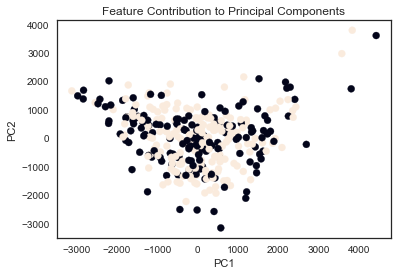

Nombre de dimensions original : 256
18  dimensions pour 90 % de variance
SVC :
	Accuracy = 0.55 (Meilleurs paramètres : {'C': 0.01, 'kernel': 'poly', 'tol': 0.10000000000000001}
	Train accuracy : 1.00
LogisticRegression :
	Accuracy = 0.56 (Meilleurs paramètres : {'C': 0.001, 'penalty': 'l2'}
	Train accuracy : 0.99
KNN :
	Accuracy = 0.57 (Meilleurs paramètres : {'n_neighbors': 11}
	Train accuracy : 0.67
KMeans :


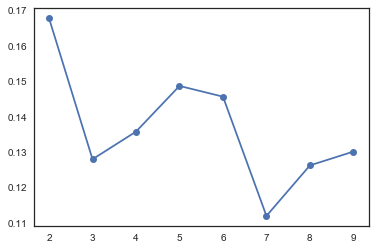

Une classification sur les histogrammes seuls n'est pas efficiente
Wall time: 2min 54s


In [385]:
%%time
# mesImages.hist()
mesImages.myTraining(p_pca=False, p_histo=True)
print("Une classification sur les histogrammes seuls n'est pas efficiente")

Normalisation
len X0 : 10000
PCA
Variance Explained 2 composants : 0.283840724832


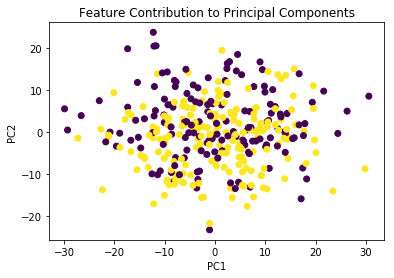

Nombre de dimensions original : 10000
118  dimensions pour 90 % de variance
SVC :
	Accuracy = 0.72 (Meilleurs paramètres : {'C': 10.0, 'kernel': 'rbf', 'tol': 0.10000000000000001}
	Train accuracy : 0.86
LogisticRegression :
	Accuracy = 0.69 (Meilleurs paramètres : {'C': 1.0, 'penalty': 'l1'}
	Train accuracy : 0.98
KNN :
	Accuracy = 0.59 (Meilleurs paramètres : {'n_neighbors': 7}
	Train accuracy : 0.69
KMeans :


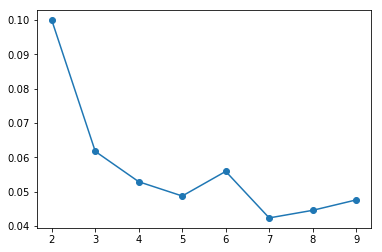

Normaliser donne de meilleurs résultats
Wall time: 16min 45s


In [308]:
%%time
mesImages.myTraining(p_norm=True)
print("Normaliser donne de meilleurs résultats")

Whiten
len X0 : 10000
PCA
Variance Explained 2 composants : 0.298432541019


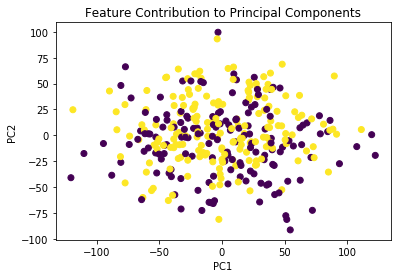

Nombre de dimensions original : 10000
118  dimensions pour 90 % de variance
SVC :
	Accuracy = 0.72 (Meilleurs paramètres : {'C': 1.0, 'kernel': 'rbf', 'tol': 9.9999999999999995e-07}
	Train accuracy : 0.94
LogisticRegression :
	Accuracy = 0.68 (Meilleurs paramètres : {'C': 0.10000000000000001, 'penalty': 'l1'}
	Train accuracy : 0.87
KNN :
	Accuracy = 0.61 (Meilleurs paramètres : {'n_neighbors': 7}
	Train accuracy : 0.70
KMeans :


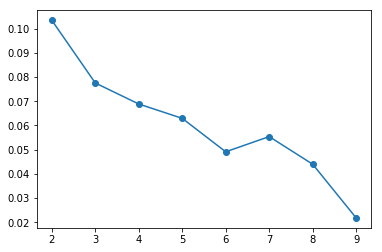

Whitening uniquement est la meilleure solution avant d'utiliser les descripteurs
Wall time: 17min 4s


In [309]:
%%time
mesImages.myTraining(p_whiten=True)
print("Whitening uniquement est la meilleure solution avant d'utiliser les descripteurs")

Normalisation
Whiten
len X0 : 10000
PCA
Variance Explained 2 composants : 0.298432541019


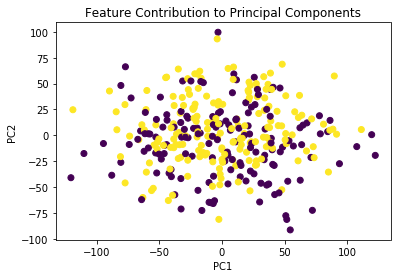

Nombre de dimensions original : 10000
118  dimensions pour 90 % de variance
SVC :
	Accuracy = 0.72 (Meilleurs paramètres : {'C': 1.0, 'kernel': 'rbf', 'tol': 9.9999999999999995e-07}
	Train accuracy : 0.94
LogisticRegression :
	Accuracy = 0.68 (Meilleurs paramètres : {'C': 0.10000000000000001, 'penalty': 'l1'}
	Train accuracy : 0.87
KNN :
	Accuracy = 0.61 (Meilleurs paramètres : {'n_neighbors': 7}
	Train accuracy : 0.70
KMeans :


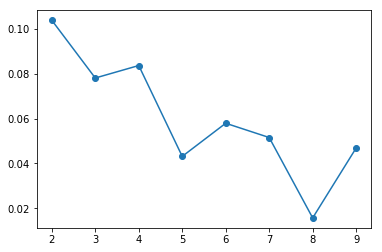

Wall time: 16min 54s


In [310]:
%%time
mesImages.myTraining(p_whiten=True, p_norm=True)

Normalisation
len X0 : 40000
PCA
Variance Explained 2 composants : 0.284216670826


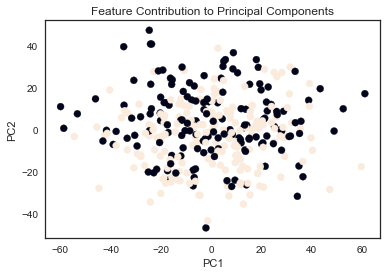

Nombre de dimensions original : 40000
118  dimensions pour 90 % de variance
SVC :


KeyboardInterrupt: 

In [477]:
# %%time
mesImages.myTraining(p_canny=True, p_norm=True)

### Evolution avec le nombre de classes

2 races : ['Chihuahua', 'Japanese_spaniel']
337 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.298874721378


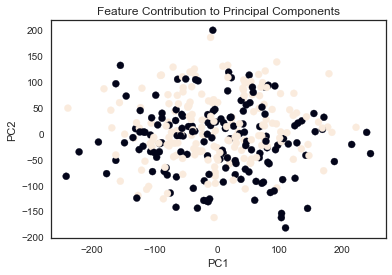

Nombre de dimensions original : 40000
117  dimensions pour 90 % de variance
SVC :
	Accuracy = 0.72 (Meilleurs paramètres : {'C': 1.0, 'kernel': 'rbf', 'tol': 0.10000000000000001}
	Train accuracy : 0.94
LogisticRegression :
	Accuracy = 0.66 (Meilleurs paramètres : {'C': 0.10000000000000001, 'penalty': 'l1'}
	Train accuracy : 0.87
KNN :
	Accuracy = 0.60 (Meilleurs paramètres : {'n_neighbors': 7}
	Train accuracy : 0.70
KMeans :


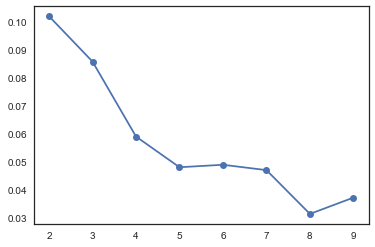

3 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']
589 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.295888549052


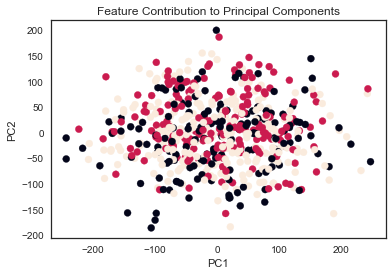

Nombre de dimensions original : 40000
147  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.93
	Test accuracy : 0.62
LogisticRegression :
	Train accuracy : 0.86
	Test accuracy : 0.55
KNN :
	Train accuracy : 0.59
	Test accuracy : 0.47
KMeans :


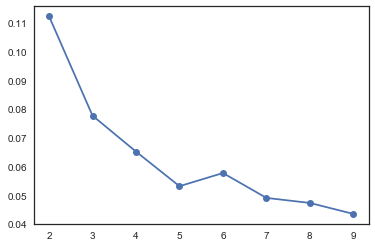

4 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese']
738 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.306562763913


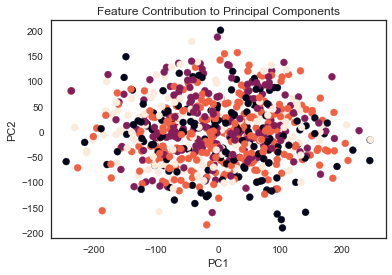

Nombre de dimensions original : 40000
161  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.89
	Test accuracy : 0.48
LogisticRegression :
	Train accuracy : 0.81
	Test accuracy : 0.44
KNN :
	Train accuracy : 0.49
	Test accuracy : 0.35
KMeans :


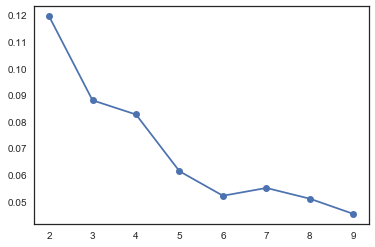

5 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu']
952 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.307469516458


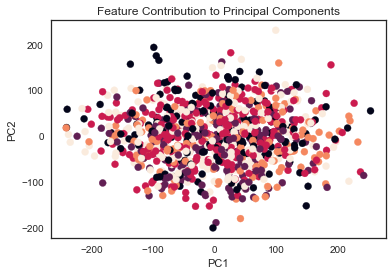

Nombre de dimensions original : 40000
186  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.85
	Test accuracy : 0.40
LogisticRegression :
	Train accuracy : 0.78
	Test accuracy : 0.34
KNN :
	Train accuracy : 0.46
	Test accuracy : 0.29
KMeans :


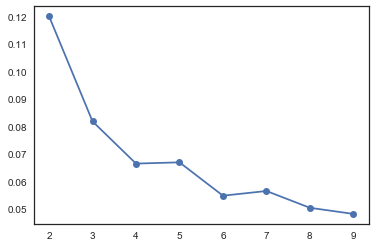

6 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel']
1140 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.29837498748


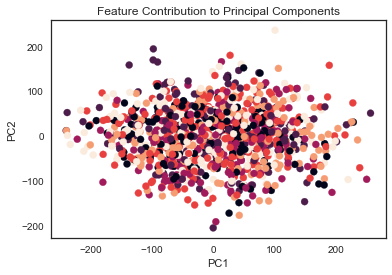

Nombre de dimensions original : 40000
215  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.83
	Test accuracy : 0.33
LogisticRegression :
	Train accuracy : 0.80
	Test accuracy : 0.30
KNN :
	Train accuracy : 0.45
	Test accuracy : 0.27
KMeans :


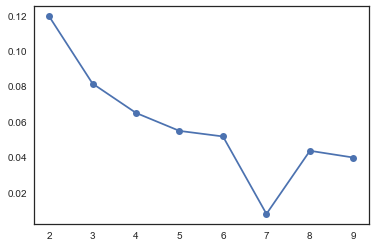

7 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon']
1336 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.295462909223


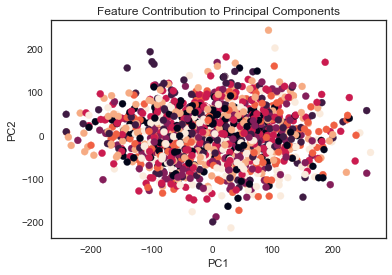

Nombre de dimensions original : 40000
230  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.82
	Test accuracy : 0.30
LogisticRegression :
	Train accuracy : 0.77
	Test accuracy : 0.28
KNN :
	Train accuracy : 0.40
	Test accuracy : 0.24
KMeans :


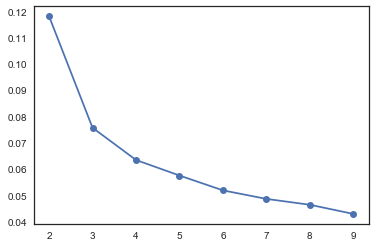

8 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier']
1508 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.30147721144


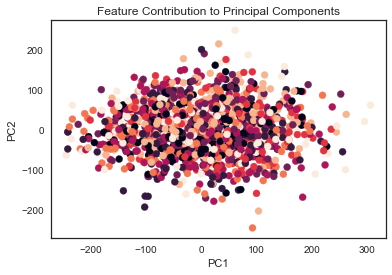

Nombre de dimensions original : 40000
246  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.81
	Test accuracy : 0.28
LogisticRegression :
	Train accuracy : 0.77
	Test accuracy : 0.25
KNN :
	Train accuracy : 0.38
	Test accuracy : 0.21
KMeans :


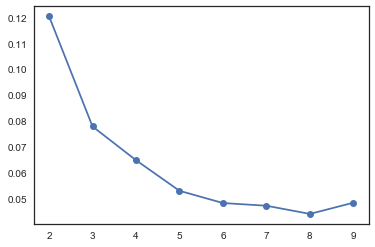

9 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback']
1680 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.303275790641


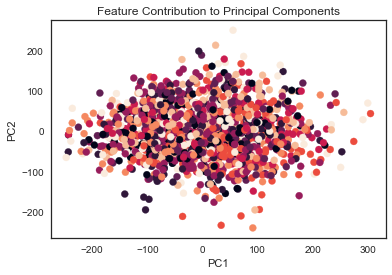

Nombre de dimensions original : 40000
268  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.81
	Test accuracy : 0.29
LogisticRegression :
	Train accuracy : 0.77
	Test accuracy : 0.24
KNN :
	Train accuracy : 0.35
	Test accuracy : 0.17
KMeans :


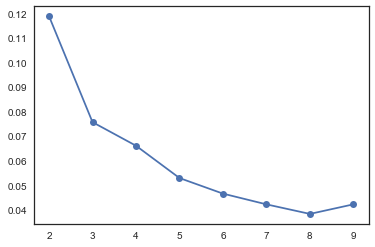

10 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound']
1919 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.302837140848


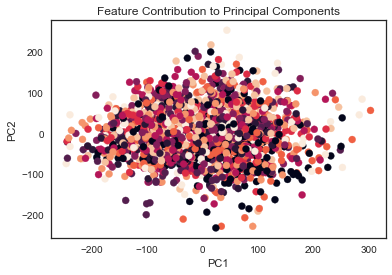

Nombre de dimensions original : 40000
301  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.78
	Test accuracy : 0.29
LogisticRegression :
	Train accuracy : 0.76
	Test accuracy : 0.24
KNN :
	Train accuracy : 0.35
	Test accuracy : 0.15
KMeans :


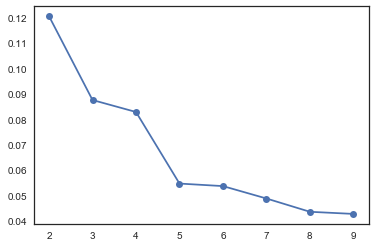

11 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset']
2094 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.302136732063


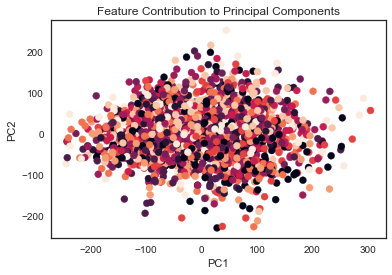

Nombre de dimensions original : 40000
318  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.77
	Test accuracy : 0.25
LogisticRegression :
	Train accuracy : 0.75
	Test accuracy : 0.22
KNN :
	Train accuracy : 0.34
	Test accuracy : 0.15
KMeans :


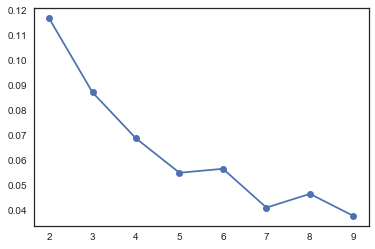

12 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle']
2289 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.304078019673


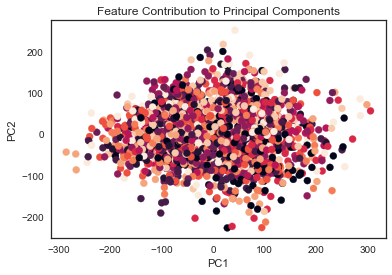

Nombre de dimensions original : 40000
329  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.75
	Test accuracy : 0.22
LogisticRegression :
	Train accuracy : 0.75
	Test accuracy : 0.20
KNN :
	Train accuracy : 0.31
	Test accuracy : 0.14
KMeans :


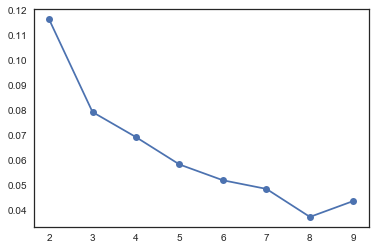

13 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound']
2476 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.302392916218


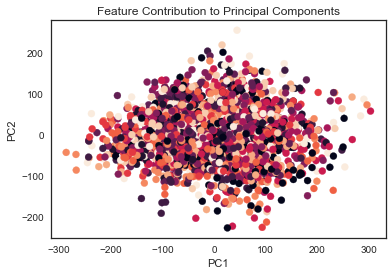

Nombre de dimensions original : 40000
346  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.75
	Test accuracy : 0.21
LogisticRegression :
	Train accuracy : 0.76
	Test accuracy : 0.18
KNN :
	Train accuracy : 0.31
	Test accuracy : 0.13
KMeans :


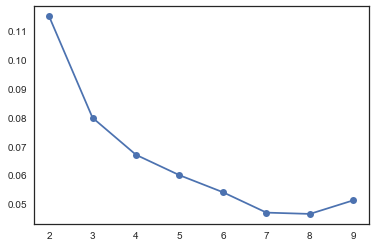

14 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick']
2647 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.300721480155


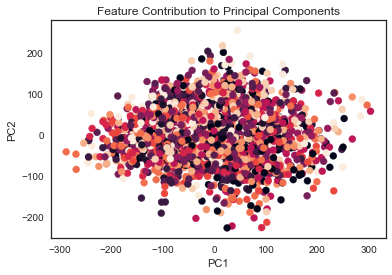

Nombre de dimensions original : 40000
369  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.74
	Test accuracy : 0.20
LogisticRegression :
	Train accuracy : 0.76
	Test accuracy : 0.17
KNN :
	Train accuracy : 0.30
	Test accuracy : 0.13
KMeans :


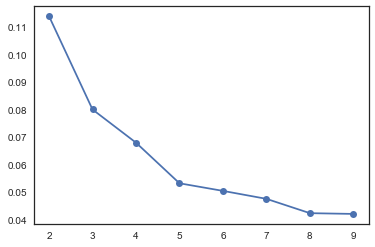

15 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound']
2806 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.299081620695


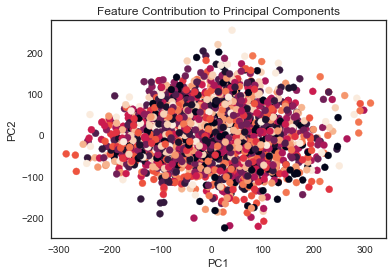

Nombre de dimensions original : 40000
375  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.73
	Test accuracy : 0.19
LogisticRegression :
	Train accuracy : 0.75
	Test accuracy : 0.17
KNN :
	Train accuracy : 0.29
	Test accuracy : 0.13
KMeans :


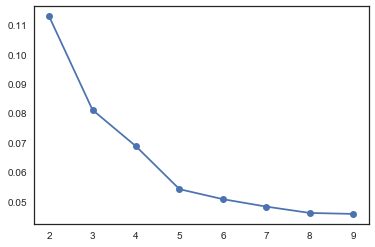

16 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound']
2959 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.297420354369


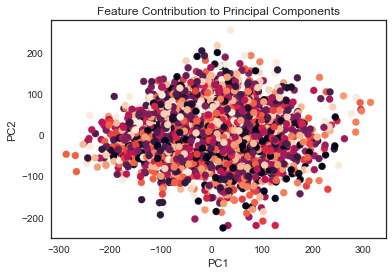

Nombre de dimensions original : 40000
388  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.72
	Test accuracy : 0.19
LogisticRegression :
	Train accuracy : 0.76
	Test accuracy : 0.16
KNN :
	Train accuracy : 0.29
	Test accuracy : 0.11
KMeans :


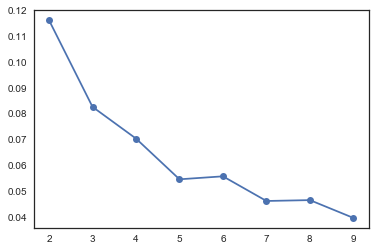

17 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound']
3116 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.295850359269


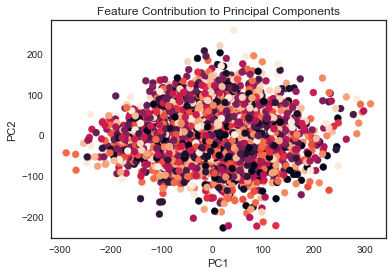

Nombre de dimensions original : 40000
401  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.73
	Test accuracy : 0.19
LogisticRegression :
	Train accuracy : 0.77
	Test accuracy : 0.16
KNN :
	Train accuracy : 0.30
	Test accuracy : 0.11
KMeans :


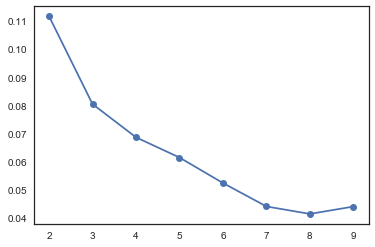

18 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone']
3264 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.29513376096


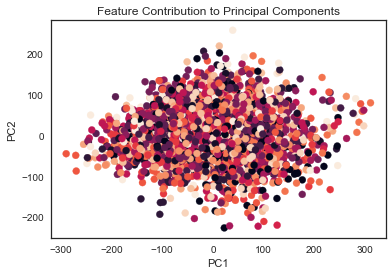

Nombre de dimensions original : 40000
410  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.72
	Test accuracy : 0.17
LogisticRegression :
	Train accuracy : 0.76
	Test accuracy : 0.15
KNN :
	Train accuracy : 0.30
	Test accuracy : 0.10
KMeans :


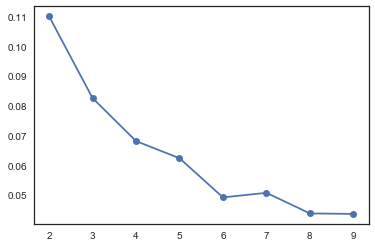

19 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi']
3415 images
Whiten
len X0 : 40000
PCA
Variance Explained 2 composants : 0.294508416896


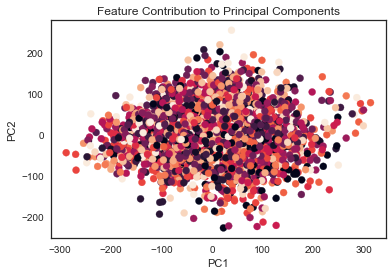

Nombre de dimensions original : 40000
421  dimensions pour 90 % de variance
SVC :
	Train accuracy : 0.71
	Test accuracy : 0.16
LogisticRegression :
	Train accuracy : 0.77
	Test accuracy : 0.15
KNN :
	Train accuracy : 0.30
	Test accuracy : 0.10
KMeans :


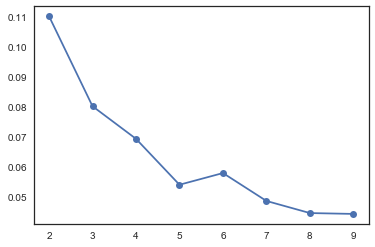

ValueError: x and y must have same first dimension, but have shapes (8,) and (18,)

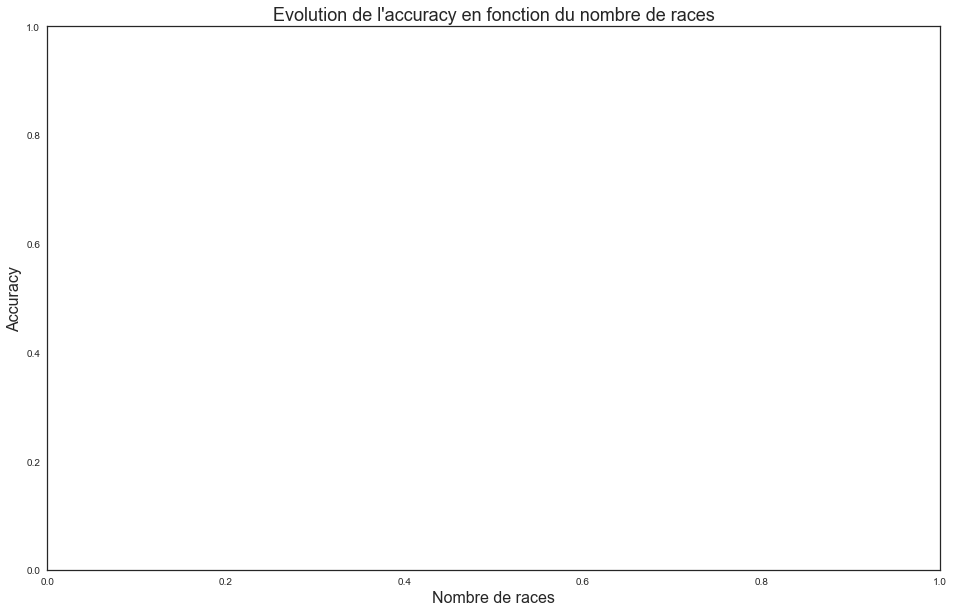

In [393]:
%%time
best_acc = []
r = range(2, 20)
for i in r:
    # Chargement des images
    mesImages = myImages(CT_DIR_DATA_IMAGES, p_nb_races=i, w_min=200, h_min=200)
    # Récupération du meilleur score
    best_acc.append(mesImages.myTraining(p_whiten=True))
plt.figure(figsize=(16,10))
plt.title("Evolution de l'accuracy en fonction du nombre de races", fontsize=18)
plt.xlabel('Nombre de races', fontsize=16)
plt.xticks(r)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(r, best_acc)
plt.show()

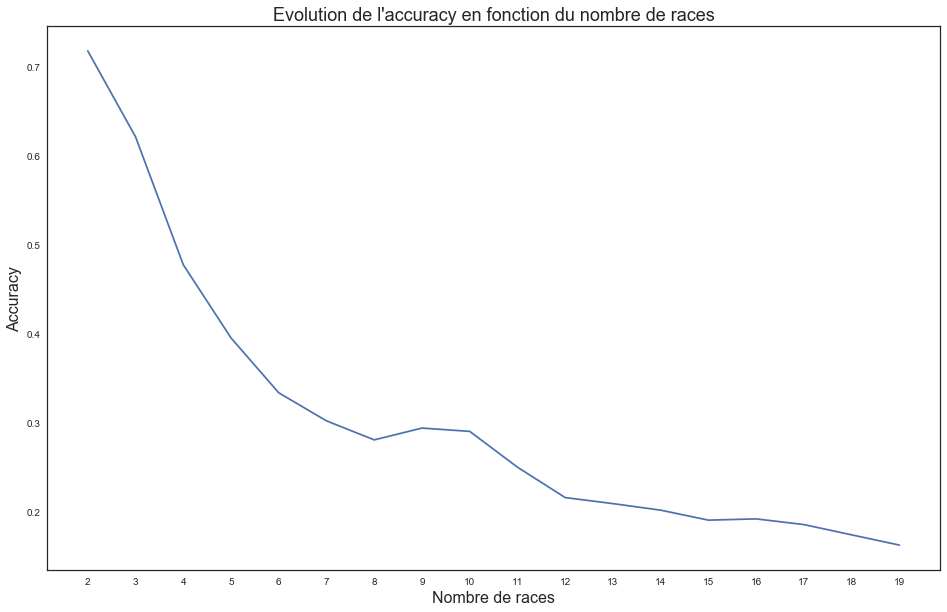

In [400]:
r = range(2, 20)
plt.figure(figsize=(16,10))
plt.title("Après whitening : Accuracy en fonction du nombre de races", fontsize=18)
plt.xlabel('Nombre de races', fontsize=16)
plt.xticks(r)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(r, best_acc)
plt.show()

On voit ici les performances de la classification chuter drastiquement lorsque le nombre de races augmentent 

## Utilisation des descripteurs

In [405]:
# Chargement des images
mesImages = myImages(CT_DIR_DATA_IMAGES, p_nb_races=2, w_min=200, h_min=200)

2 races : ['Chihuahua', 'Japanese_spaniel']
337 images


Nombre de descripteurs : 33393
PCA
Variance Explained 2 composants : 0.197766


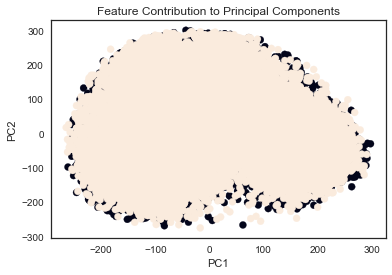

Nombre de dimensions original : 128
54  dimensions pour 90 % de variance


54

In [361]:
%%time
mesImages.prepareDesc(p_whiten=False, p_canny=False, p_sobel_x=False, p_sobel_y=False, p_laplace=False)
displayPCA(mesImages.bow, mesImages.y_bow)

Nombre de descripteurs : 27664
PCA
Variance Explained 2 composants : 0.137867


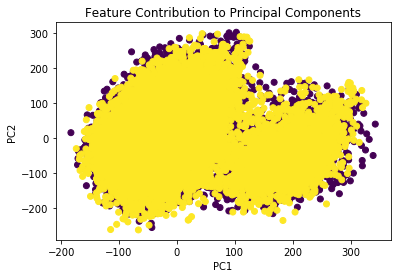

In [198]:
%%time
mesImages.prepareDesc(p_whiten=False, p_canny=True, p_sobel_x=False, p_sobel_y=False, p_laplace=False)
displayPCA(mesImages.bow, mesImages.y_bow)

Nombre de descripteurs : 17606
PCA
Variance Explained 2 composants : 0.212556


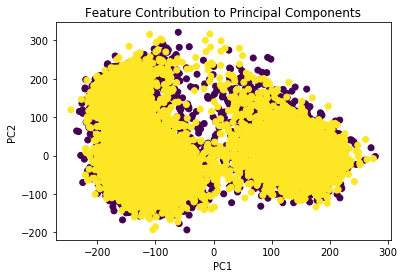

In [199]:
%%time
mesImages.prepareDesc(p_whiten=False, p_canny=False, p_sobel_x=True, p_sobel_y=False, p_laplace=False)
displayPCA(mesImages.bow, mesImages.y_bow)

Nombre de descripteurs : 17639
PCA
Variance Explained 2 composants : 0.211688


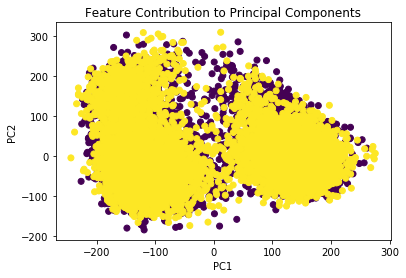

In [200]:
%%time
mesImages.prepareDesc(p_whiten=False, p_canny=False, p_sobel_x=False, p_sobel_y=True, p_laplace=False)
displayPCA(mesImages.bow, mesImages.y_bow)

Nombre de descripteurs : 22354
PCA
Variance Explained 2 composants : 0.219925


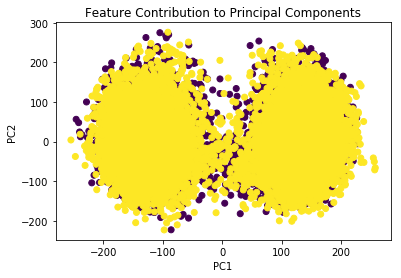

In [201]:
%%time
mesImages.prepareDesc(p_whiten=False, p_canny=False, p_sobel_x=False, p_sobel_y=False, p_laplace=True)
displayPCA(mesImages.bow, mesImages.y_bow)

Nombre de descripteurs : 33815
PCA
Variance Explained 2 composants : 0.242901


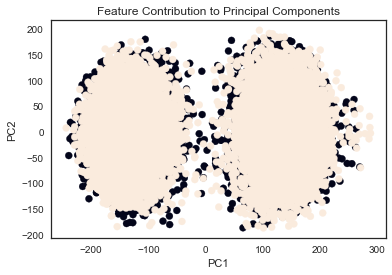

Nombre de dimensions original : 128
65  dimensions pour 90 % de variance


In [406]:
%%time
mesImages.prepareDesc(p_whiten=False, p_canny=False, p_sobel_x=True, p_sobel_y=True, p_laplace=True)
best_n_components = displayPCA(mesImages.bow, mesImages.y_bow)

In [407]:
print(mesImages.y_bow[5607])
print(mesImages.y_bow[5608])

[ 0.]
[ 0.]


### Transformation des descripteurs en visual bag of words

In [6]:
def prepareBagOfFeatures(p_whiten=False, p_canny=False, p_sobel_x=True, p_sobel_y=True, p_laplace=True):
    # On applique certains filtres aux descripteurs
    mesImages.prepareDesc(p_whiten=False, p_canny=False, p_sobel_x=True, p_sobel_y=True, p_laplace=True)
    # On défini 1000 clusters, base de notre dictionnaire de features
    k = 1000
    cls = cluster.KMeans(n_clusters=k) 
    cls.fit(mesImages.bow)
    # Les centres des clusters vont être les visual words de notre dico
    img_visualwords=[]
    for img_desc in mesImages.desc:
        img_visualwords.append(cls.predict(img_desc))
    # On peut maintenant décrire chaque image par un histogramme indiquant la fréquence d'apparition de chaque visual word du dico
    bags_of_features=[]
    for img_vw in img_visualwords:
        hist, bin_edges = np.histogram(img_vw, np.arange(cls.n_clusters))
        bags_of_features.append(hist)

    X = StandardScaler().fit_transform(np.array(bags_of_features))

    # GridSearchCV
    mod = SVC()
    C_range = np.logspace(-2, 3, 6)
    tol_range = np.logspace(-6, -1, 6)
    gamma_range = 10. ** np.arange(-5, 4)
    kernel_range = ['linear', 'rbf', 'poly']
#     param_grid = {'C': C_range, 'gamma': gamma_range, 'tol': tol_range, 'kernel' : kernel_range}
    param_grid = {'C' : [0.01], 'gamma': [0.00001], 'tol': [0.000001], 'kernel' : ['linear']}
    cls = GridSearchCV(mod, param_grid, cv=5, scoring='accuracy')
    cls.fit(X, mesImages.y_enc)
    print("\tAccuracy = %.2f (Meilleurs paramètres : %s" % (cls.best_score_, cls.best_params_))

    best_res = cls.best_score_
    return best_res



In [443]:
%%time
prepareBagOfFeatures(p_whiten=False, p_canny=False, p_sobel_x=True, p_sobel_y=True, p_laplace=True)


Nombre de descripteurs : 33815


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


	Accuracy = 0.48 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
Wall time: 5min 43s


0.48071216617210683

2 races : ['Chihuahua', 'Japanese_spaniel']
337 images
Nombre de descripteurs : 33815


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.52 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
3 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']
589 images
Nombre de descripteurs : 59105


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.36 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
4 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese']
738 images
Nombre de descripteurs : 74059


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.30 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
5 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu']
952 images
Nombre de descripteurs : 95534


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.23 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
6 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel']
1140 images
Nombre de descripteurs : 114388


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.17 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
7 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon']
1336 images
Nombre de descripteurs : 134061


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.13 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
8 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier']
1508 images
Nombre de descripteurs : 151320


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.14 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
9 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback']
1680 images
Nombre de descripteurs : 168588


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.13 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
10 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound']
1919 images
Nombre de descripteurs : 192570


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.10 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
11 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset']
2094 images
Nombre de descripteurs : 210135


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.10 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
12 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle']
2289 images
Nombre de descripteurs : 229709


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.08 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
13 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound']
2476 images
Nombre de descripteurs : 248479


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.08 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
14 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick']
2647 images
Nombre de descripteurs : 265636


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.08 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
15 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound']
2806 images
Nombre de descripteurs : 281592


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.08 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
16 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound']
2959 images
Nombre de descripteurs : 296950


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.07 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
17 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound']
3116 images
Nombre de descripteurs : 312708


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.06 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
18 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone']
3264 images
Nombre de descripteurs : 327571


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.06 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
19 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi']
3415 images
Nombre de descripteurs : 342729


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


	Accuracy = 0.06 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}


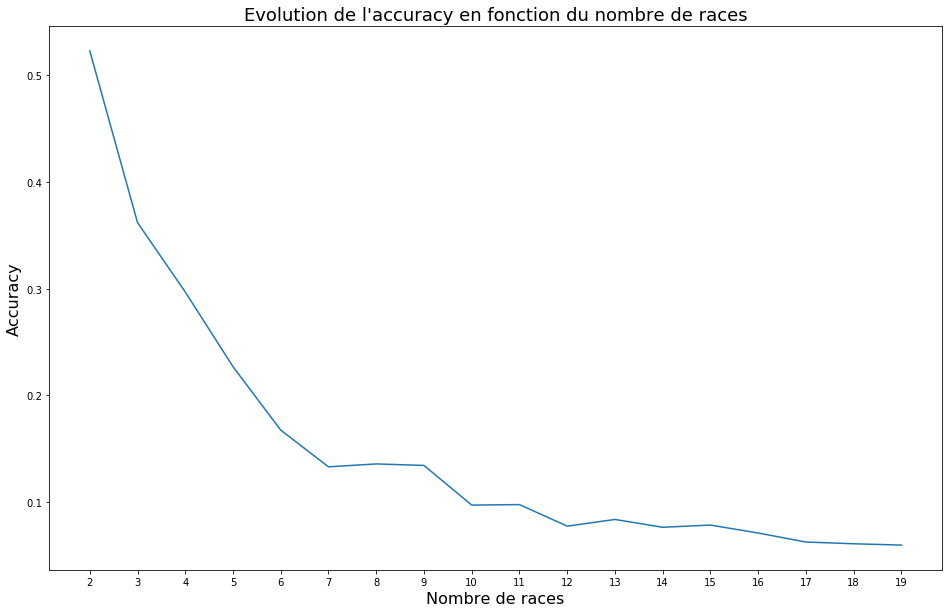

Wall time: 23h 40min 46s


In [8]:
%%time
CT_DIR_DATA_IMAGES = 'C:\Work\OpenClassrooms\data\P7\Images/'
best_acc = []
r = range(2, 20)
for i in r:
    # Chargement des images
    mesImages = myImages(CT_DIR_DATA_IMAGES, p_nb_races=i, w_min=200, h_min=200)
    acc = prepareBagOfFeatures(p_whiten=False, p_canny=False, p_sobel_x=True, p_sobel_y=True, p_laplace=True)
    best_acc.append(acc)
    del mesImages
plt.figure(figsize=(16,10))
plt.title("Evolution de l'accuracy en fonction du nombre de races", fontsize=18)
plt.xlabel('Nombre de races', fontsize=16)
plt.xticks(r)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(r, best_acc)
plt.show()

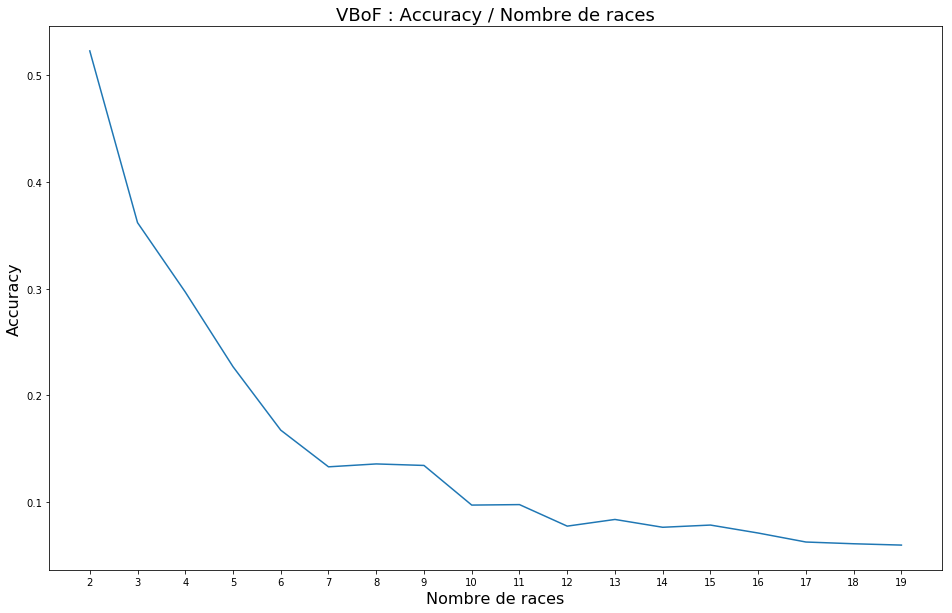

In [10]:
plt.figure(figsize=(16,10))
plt.title("VBoF : Accuracy / Nombre de races", fontsize=18)
plt.xlabel('Nombre de races', fontsize=16)
plt.xticks(r)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(r, best_acc)
plt.show()

In [445]:
%%time
# Perform k-means clustering
k = 1000
cls = cluster.KMeans(n_clusters=k) 
cls.fit(mesImages.bow)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Wall time: 5min 34s


In [409]:
%%time
img_visualwords=[]
for img_desc in mesImages.desc:
    img_visualwords.append(cls.predict(img_desc)) 

In [410]:
img_visualwords[0][:10]

array([780, 629, 904, 335, 750, 686, 730, 412, 175, 979])

In [411]:
%%time
bags_of_features=[]
for img_vw in img_visualwords:
    hist, bin_edges = np.histogram(img_vw, np.arange(cls.n_clusters))
    bags_of_features.append(hist) 

In [446]:
bags_of_features[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [412]:
print(len(mesImages.desc))
print(len(img_visualwords))
print(len(bags_of_features))
print(len(mesImages.y_enc))

337
337
337
337


In [438]:
%%time
X = StandardScaler().fit_transform(np.array(bags_of_features))
# GridSearchCV
mod = SVC()
C_range = np.logspace(-2, 3, 6)
tol_range = np.logspace(-6, -1, 6)
gamma_range = 10. ** np.arange(-5, 4)
kernel_range = ['linear', 'rbf', 'poly']
# kernel_range = ['linear']
param_grid = {'C': C_range, 'gamma': gamma_range, 'tol': tol_range, 'kernel' : kernel_range}
# param_grid = {'C' : [0.01], 'gamma': [0.00001], 'tol': [0.000001], 'kernel' : kernel_range}
cls = GridSearchCV(mod, param_grid, cv=5, scoring='accuracy')
# X = np.array(bags_of_features)
cls.fit(X, mesImages.y_enc)
print("\tAccuracy = %.3f (Meilleurs paramètres : %s" % (cls.best_score_, cls.best_params_))
cls.best_estimator_

	Accuracy = 0.558 (Meilleurs paramètres : {'C': 0.01, 'gamma': 1e-05, 'kernel': 'linear', 'tol': 1e-06}
Wall time: 1.19 s


In [439]:
%%time
X_train, X_test, y_train, y_test = train_test_split(np.array(bags_of_features), mesImages.y_enc, stratify=mesImages.y_enc, test_size=0.25, random_state=10)
svc = SVC(C=0.01, gamma=0.00001, tol=0.000001, kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('SVC - accuracy score sur le jeu X_train: %.2f' % accuracy_score(y_train, svc.predict(X_train)))
print('SVC - accuracy score sur le jeu X_test: %.2f' % accuracy_score(y_test, y_pred))

SVC - accuracy score sur le jeu X_train: 0.98
SVC - accuracy score sur le jeu X_test: 0.52
Wall time: 207 ms


In [441]:
svc

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=1e-06, verbose=False)

PCA
Variance Explained 2 composants : 0.0168217493171


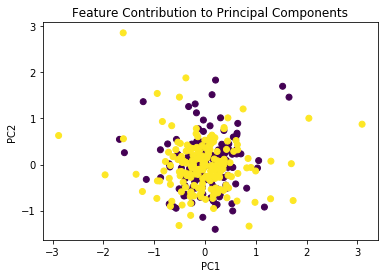

Nombre de dimensions original : 999
236  dimensions pour 90 % de variance
SVC - accuracy score sur le jeu X_train: 1.00
SVC - accuracy score sur le jeu X_test: 0.54


In [241]:
best_n_components = displayPCA(np.array(bags_of_features), mesImages.y_enc)
# if True:
#     cls = decomposition.PCA(n_components=best_n_components, whiten=True)
#     cls.fit(np.array(bags_of_features))
#     X_train = cls.transform(X_train)
#     X_test = cls.transform(X_test)
    
# svc = SVC()
# svc.fit(X_train, y_train)
# y_pred = svc.predict(X_test)
# print('SVC - accuracy score sur le jeu X_train: %.2f' % accuracy_score(y_train, svc.predict(X_train)))
# print('SVC - accuracy score sur le jeu X_test: %.2f' % accuracy_score(y_test, y_pred))

In [ ]:
best_n_components = displayPCA(X, mesImages.y_enc)


In [ ]:
%%time
best_acc = []
r = range(2, 10)
for i in r:
    # Chargement des images
    mesImages = myImages(CT_DIR_DATA_IMAGES, p_nb_races=i, w_min=200, h_min=200)
    # Récupération du meilleur score
    best_acc.append(mesImages.myTraining(p_whiten=True))
plt.figure(figsize=(16,10))
plt.title("Evolution de l'accuracy en fonction du nombre de races", fontsize=18)
plt.xlabel('Nombre de races', fontsize=16)
plt.xticks(r)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(r, best_acc)
plt.show()

In [ ]:
%%time
# Toutes les images
CT_DIR_DATA_IMAGES = 'C:\Work\OpenClassrooms\data\P7\Images/'
mesImages = myImages(CT_DIR_DATA_IMAGES)
mesImages.myTraining(p_whiten=True)


20579 images
120 races
Whiten
len X0 : 40000
SVC : 

20580 images

120 races

Largeur min : 97 px, hauteur min : 100 px

AUC moyenne : 0.522594734771

Wall time: 4min 12s

## CNN - Keras

In [ ]:
# # Exemple dont l'entrainement peut prendre un mois...
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D
# my_VGG16 = Sequential()  # Création d'un réseau de neurones vide 
# # Ajout de la première couche de convolution, suivie d'une couche ReLU
# my_VGG16.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
# # Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
# my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# # Ajout de la première couche de pooling
# my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# from keras.layers import Flatten, Dense
# my_VGG16.add(Flatten())  # Conversion des matrices 3D en vecteur 1D
# # Ajout de la première couche fully-connected, suivie d'une couche ReLU
# my_VGG16.add(Dense(4096, activation='relu'))
# # Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
# my_VGG16.add(Dense(4096, activation='relu'))
# # Ajout de la dernière couche fully-connected qui permet de classifier
# my_VGG16.add(Dense(1000, activation='softmax'))

### Utilisation du VGG-16 pré-entraîné

In [29]:
%%time
from keras.applications.vgg16 import VGG16
model = VGG16() # Création du modèle VGG-16 implementé par Keras

Using TensorFlow backend.


Wall time: 15.1 s


In [32]:
from MSO_UTILS.MSO_functions import *
# CT_DIR_DATA = 'MSO_DATA/'
# model.save(CT_DIR_DATA+'VGG16')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
img = load_img(CT_DIR_DATA+'ferret.jpg', target_size=(224, 224))  # Charger l'image

w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))
print("Format des pixels : {}".format(img.mode))

img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [ ]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

from keras.applications.vgg16 import decode_predictions
# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

### Transfer Learning

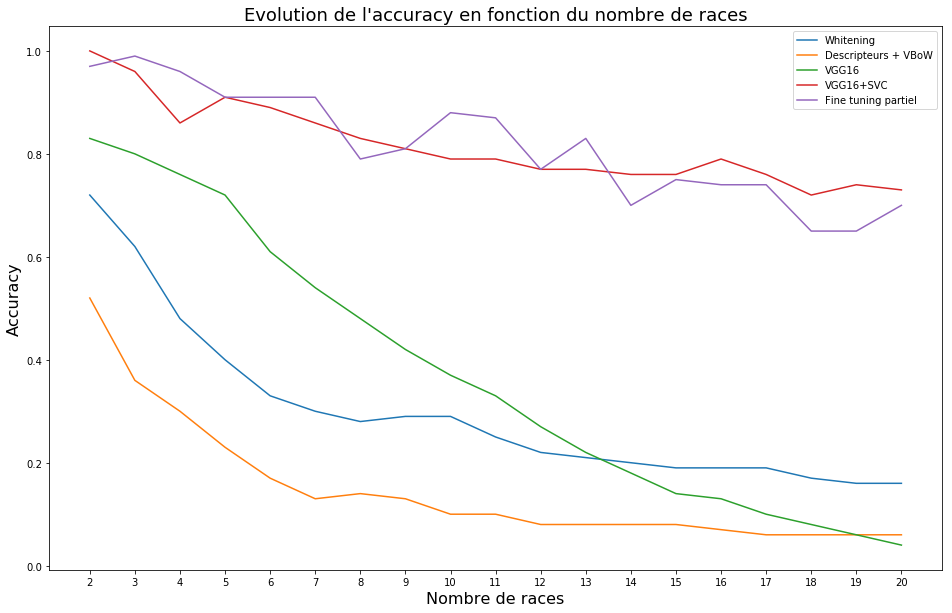

In [11]:
r = range(2, 21)
acc_whiten = [.72, 0.62, 0.48, 0.40, 0.33, 0.30, 0.28, 0.29, 0.29, .25, .22, .21, .20, .19, .19, .19, .17, .16, .16]
acc_descr = [.52, 0.36, 0.30, 0.23, 0.17, 0.13, 0.14, 0.13, 0.10, .10, .08, .08, .08, .08, .07, .06, .06, .06, .06]
acc_vgg = [.83, 0.80, 0.76, 0.72, 0.61, 0.54, 0.48, 0.42, 0.37, .33, .27, .22, .18, .14, .13, .10, .08, .06, .04]
acc_vgg_svc = [1.00, 0.96, 0.86, 0.91, 0.89, 0.86, 0.83, 0.81, 0.79, .79, .77, .77, .76, .76, .79, .76, .72, .74, .73]
acc_tl_bs10 = [.97, 0.97, 0.91, 0.37, 0.58, 0.65, 0.38, 0.55, 0.31, .26, .30, .44, .42, .42, .30, .30, .30, .30, .30]
acc_tl_bs100 = [.97, 0.99, 0.96, 0.91, 0.91, 0.91, 0.79, 0.81, 0.88, .87, .77, .83, .70, .75, .74, .74, .65, .65, .70]
acc_tl_dg = [.97, ]
acc_tl_ = [0.8255814022796099,
 0.7952755924284928,
 0.7108433742121042,
 0.7205882352941176,
 0.6652892557057467,
 0.6428571445601327,
 0.5880503144654088]

plt.figure(figsize=(16,10))
plt.title("Evolution de l'accuracy en fonction du nombre de races", fontsize=18)
# plt.title("Transfer learning", fontsize=18)
plt.xlabel('Nombre de races', fontsize=16)
plt.xticks(r)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(r, acc_whiten, label='Whitening')
plt.plot(r, acc_descr, label='Descripteurs + VBoW')
plt.plot(r, acc_vgg, label='VGG16')
plt.plot(r, acc_vgg_svc, label='VGG16+SVC')
# plt.plot(r, acc_tl_bs10, label='Batch_size = 10')
plt.plot(r, acc_tl_bs100, label='Fine tuning partiel')
plt.legend()
plt.show()

In [ ]:
%%time
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# Récupérer la sortie de ce réseau
x = model.output
# Ajouter la nouvelle couche fully-connected pour la classification à 10 classes
predictions = Dense(10, activation='softmax')(x)
# Définir le nouveau modèle
new_model = Model(inputs=model.input, outputs=predictions)

In [ ]:
# Stratégie #1 : fine-tuning total
# Ici, on entraîne tout le réseau, donc il faut rendre toutes les couches "entraînables" :
for layer in model.layers:
    layer.trainable = True
    
# Stratégie #2 : extraction de features
# On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :
for layer in model.layers:
    layer.trainable = False

# Stratégie #3 : fine-tuning partiel
# On entraîne le nouveau classifieur et les couches hautes :
# Ne pas entraîner les 5 premières couches (les plus basses) 
for layer in model.layers[:5]:
    layer.trainable = False


In [ ]:
%%time
# Compiler le modèle 
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

In [265]:
# img = read_image(CT_DIR_DATA + 'simba.png')
img = read_image(CT_DIR_DATA + 'dog.jpg')
print(img[0].size)

825


In [281]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

im = image.load_img(CT_DIR_DATA + 'dog.jpg', target_size=(224, 224)) # 224*224*3 = 224*672 = 150528
im = image.img_to_array(im)
# print(im[0])
im = np.expand_dims(im, axis=0)
# print(im[0])
preprocess_input(im)

array([[[[ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732],
         ..., 
         [ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732]],

        [[ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732],
         ..., 
         [ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732]],

        [[ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732],
         ..., 
         [ 151.06100464,  138.2210083 ,  131.32000732],
         [ 151.06100464,  138.2210083 ,  131.32000732],

In [ ]:
  x = image.img_to_array(im)
  # Créer la collection d'images (un seul échantillon)
  # img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  x = np.expand_dims(x, axis=0)
  # Prétraiter l'image comme le veut VGG-16
#   x = preprocess_input(x)


In [478]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 

class MyImages:
    # Chargement des images du dossier CT_DIR_DATA
    def __init__(self, p_dir, p_nb_races):
        # Correspondance code/race
#         self.races = dict([(f.split('-')[0], f[f.find('-') + len('-'):]) for f in os.listdir(p_dir)])
        nb_races = 0
        self.races = []
        for f in os.listdir(p_dir):
            self.races.append((f.split('-')[0], f[f.find('-') + len('-'):]))
            nb_races += 1
            if nb_races == p_nb_races: break
        self.races = dict(self.races)
        print(len(self.races), 'races :', list(self.races.values()))

        # Liste des fichiers
        self.lst_files = []
        images = []
        nb_races = 0
        for path, dirs, files in os.walk(p_dir):
            if len(files) > 0: nb_races += 1
            for filename in files:
                images.append(filename)
                self.lst_files.append(os.path.join(path, filename))
            # Si on a assez de races on arrête
            if nb_races == p_nb_races: break

        self.labels = [i.split('_')[0] for i in images]
        print(len(images), 'images')
        print(len(self.labels), 'labels')

        # Target
        y = [self.races[lbl] for lbl in self.labels]
        self.lbl = LabelEncoder()
        self.y_enc = self.lbl.fit_transform(y)

        # Data
        self.dataVgg = []
        for file in self.lst_files:
            # Convert to gray
            img = image.load_img(file, target_size=(224,224))
            # Convertir en tableau numpy
            img = image.img_to_array(img)
            self.dataVgg.append(img)


In [479]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras.models import Model

# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# new_data1 = testModel(base_model, myTest.dataVgg, False)
# new_data2 = testModel(base_model, myTest.dataVgg, True)


58892288/58889256 [==============================] - 110s 2us/step
Wall time: 1min 54s


In [481]:
%%time
best_acc = []
r = range(2, 11)
for i in r:
    # Chargement des images
    mesImages = MyImages('C:\Work\OpenClassrooms\data\P7\Images/', p_nb_races=i)
    # Préparation
    X = preprocess_input(np.array(mesImages.dataVgg))
    Xvgg = base_model.predict(X)
    Xvgg_reshape = Xvgg.reshape(Xvgg.shape[0], -1)
    X = StandardScaler().fit_transform(Xvgg_reshape)
    X_train, X_test, y_train, y_test = train_test_split(X, mesImages.y_enc, stratify=mesImages.y_enc, test_size=0.25, random_state=10)
    # Entrainement
    svc = SVC()
    svc.fit(X_train, y_train)
    # Récupération du meilleur score
    acc = accuracy_score(y_test, svc.predict(X_test))
    best_acc.append(acc)
    print('Accuracy = %.2f' % (acc))

plt.figure(figsize=(16,10))
plt.title("Evolution de l'accuracy en fonction du nombre de races", fontsize=18)
plt.xlabel('Nombre de races', fontsize=16)
plt.xticks(r)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(r, best_acc)
plt.show()

2 races : ['Chihuahua', 'Japanese_spaniel']
337 images
337 labels


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:653: RuntimeWarning: invalid value encountered in sqrt
  self.scale_ = _handle_zeros_in_scale(np.sqrt(self.var_))


Accuracy = 0.94
3 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']
589 images
589 labels
Accuracy = 0.91
4 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese']
738 images
738 labels
Accuracy = 0.83
5 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu']
952 images
952 labels
Accuracy = 0.73
6 races : ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel']
1140 images
1140 labels


KeyboardInterrupt: 